<a id="intro"></a>
# Исследование А/В тестов для интернет-магазина

**Описание проекта**

Заказчик — отдел маркетинга крупного интернет-магазина. 

Отдел маркетинга подготовил список гипотез для увеличения выручки. Необходимо приоритизировать гипотезы, провести A/B-тест и проанализировать результаты

**Цели исследования**:
1. [Приоритизация гипотез](#hypothesis_prioritization)
2. [Статистическая значимость количества заказов](#average_number)
3. [Статистическая значимость среднего чека](#average_check)
4. [Кумулятивная выручка по группам](#cumulative_revenue)

 👉 **[Итоги исследования здесь](#research_results)**

**Описание данных**

В таблице `hypothesis.csv` **9 гипотез** по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.
- `Hypothesis` — краткое описание гипотезы,
- `Reach` — охват пользователей по 10-балльной шкале,
- `Impact` — влияние на пользователей по 10-балльной шкале,
- `Confidence` — уверенность в гипотезе по 10-балльной шкале,
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Результаты А/В тестов:

Информация о заказах — таблица `orders.csv`
- `transactionId` — идентификатор заказа,
- `visitorId` — идентификатор пользователя, совершившего заказ,
- `date` — дата, когда был совершён заказ,
- `revenue` - выручка заказа,
- `group` - группа A/B-теста, в которую попал заказ.

Информация о посетителях — таблица `visitors.csv`
- `date` — дата посещения,
- `group` — группа A/B-теста,
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста.

## Общая информация о данных

In [16]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import os
import seaborn as sns
import numpy as np
from datetime import datetime as dt
import matplotlib.ticker as mticker
import scipy.stats as st

In [17]:
# чтение файла с данными и сохранение в соответствующие датафреймы
dir1 = '/datasets/'
dir2 = '/Users/alexslobodskoj/Data_Analyst/'
hypothesis_pth = 'hypothesis.csv'
orders_pth = 'orders.csv'
visitors_pth = 'visitors.csv'


if os.path.exists(dir1):
    df_visitors, df_orders, df_hypothesis = (
        pd.read_csv(dir1 + visitors_pth),
        pd.read_csv(dir1 + orders_pth),
        pd.read_csv(dir1 + hypothesis_pth)
    )
elif os.path.exists(dir2):
    df_visitors, df_orders, df_hypothesis = (
        pd.read_csv(dir2 + visitors_pth),
        pd.read_csv(dir2 + orders_pth),
        pd.read_csv(dir2 + hypothesis_pth)
    )
else:
    print('Something is wrong')

In [18]:
# вывод информации о гипотезах `df_hypothesis`
pd.set_option('display.max_colwidth', None)
display(df_hypothesis.head(9))

# вывод основной информации
df_hypothesis.info()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


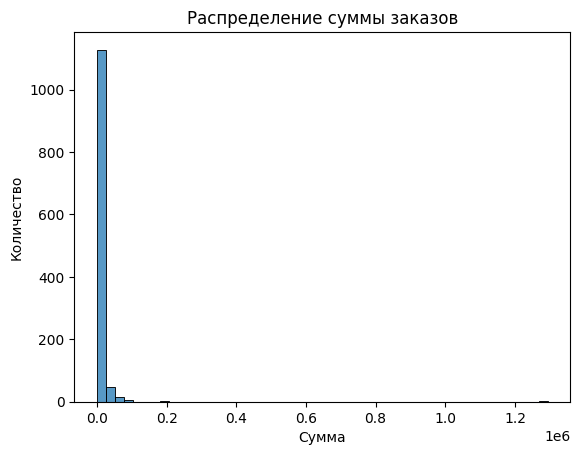

In [19]:
# датафрейм о заказа `df_orders`
# вывод первых 5 строчек 
display(df_orders.head())

# вывод основной информации
df_orders.info()

# гистограмма для столбца `revenue`
sns.histplot(df_orders['revenue'], bins=50)
plt.title('Распределение суммы заказов')
plt.ylabel('Количество')
plt.xlabel('Сумма')
plt.show()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


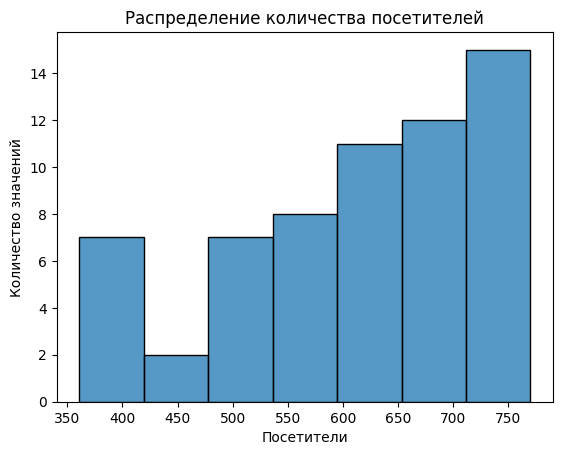

In [20]:
# датафрейм о посещениях `df_visitors`
# вывод первых 5 строк 
display(df_visitors.head())

# вывод основной информации
df_visitors.info()

# гистограмма для столбца `visitors`
sns.histplot(df_visitors['visitors'])
plt.title('Распределение количества посетителей')
plt.ylabel('Количество значений')
plt.xlabel('Посетители')
plt.show()

<div style="border:solid gray 1px; padding: 20px">

**Выводы:**

1. В таблицах нет пропущенных значений

2. В столбцах `date` таблиц `df_orders` и `df_visitors` необходимо изменить тип данных

3. В суммах заказов есть аномальные значения

4. Необходимо проверить таблицы `df_orders` и `df_visitors` на наличие дубликатов

5. Необходимо проверить корректность результатов проведения теста

## Предобработка данных

### Изменение типа данных

В столбцах `date` таблиц `df_orders` и `df_visitors` необходимо изменить тип данных с текстового на DateTime

In [21]:
# изменение типа данных в соотв. столбцах
df_visitors['date'] = pd.to_datetime(df_visitors['date'], format='%Y-%m-%d')
df_orders['date'] = pd.to_datetime(df_orders['date'], format='%Y-%m-%d')

### Проверка наличия дубликатов

Проверим наличие явных дубликатов

In [22]:
# создание словаря датафреймов
dataframes = {'df_visitors': df_visitors, 'df_orders': df_orders}

# вывод названий таблиц и количество явных дубликатов в них
for name, df in dataframes.items():
    if df.duplicated().sum() > 0:
        display(
            Markdown(
                f'**{df.duplicated().sum()}**'
                f' явных дубликатов строк в таблице: '
                f'{name}')
        )
    else:
        display(
            Markdown(
                f'Нет явных дубликатов в таблице: '
                f'{name}')
        )

Нет явных дубликатов в таблице: df_visitors

Нет явных дубликатов в таблице: df_orders

Проверим наличие неявных дубликатов в столбцах `group` таблиц `df_visitors` и `df_orders`

In [23]:
# вывод отсортированного уникального списка значений в 'group'
display(df_visitors['group'].sort_values().unique())

# вывод отсортированного уникального списка значений в 'group'
display(df_orders['group'].sort_values().unique())

array(['A', 'B'], dtype=object)

array(['A', 'B'], dtype=object)

Неявных дубликатов не обнаружено.

### Проверка результатов теста

Проверим даты в `df_orders` и `df_visitors`

In [24]:
# запись уникальных дат в переменные
unique_visitors_dates = pd.to_datetime(df_visitors['date'].unique())
unique_orders_dates = pd.to_datetime(df_orders['date'].unique())

# проверка совпадения уникальных дат
dates_match = set(unique_visitors_dates) == set(unique_orders_dates)

# проверка совпадения диапазона дат
date_range_visitors = (df_visitors['date'].min(), df_visitors['date'].max())
date_range_orders = (df_orders['date'].min(), df_orders['date'].max())
ranges_match = date_range_visitors == date_range_orders

# проверка на пропущенные даты
all_dates_visitors = pd.date_range(start=date_range_visitors[0], end=date_range_visitors[1])
all_dates_orders = pd.date_range(start=date_range_orders[0], end=date_range_orders[1])

missing_dates_visitors = set(all_dates_visitors) - set(unique_visitors_dates)
missing_dates_orders = set(all_dates_orders) - set(unique_orders_dates)

# вывод результатов
if dates_match and ranges_match and not missing_dates_visitors and not missing_dates_orders:
    display(
        Markdown(
            f'Даты в обоих датафреймах совпадают, находятся в одном диапазоне и нет пропущенных дат.'
        )
    )
else:
    if not dates_match:
        display(
            Markdown(
                f'Даты в датафреймах не совпадают.'
            )
        )
    if not ranges_match:
        display(
            Markdown(
                f'Даты находятся в разных диапазонах.'
            )
        )    
    if missing_dates_visitors:
        display(
            Markdown(
                f'Пропущенные даты в df_visitors: {sorted(missing_dates_visitors)}'
            )
        )
    if missing_dates_orders:
        display(
            Markdown(
                f'Пропущенные даты в df_orders: {sorted(missing_dates_orders)}'
            )
        )

Даты в обоих датафреймах совпадают, находятся в одном диапазоне и нет пропущенных дат.

Проверим попадание заказов одних и тех же `visitorId` в разные группы тестирования.

In [25]:
# запись количества уникальных групп для каждого visitorId в столбец group_count
df_orders['group_count'] = df_orders.groupby('visitorId')['group'].transform('nunique')

# запись в переменную списка visitorId, которые находятся в более чем одной группе
multigroup_visitors = df_orders.query('group_count > 1')['visitorId'].unique()

# вывод результата
if len(multigroup_visitors) > 0:
    display(
        Markdown(
            f'Есть **{len(multigroup_visitors)}** посетителей, чьи заказы попали в разные группы тестирования.\n\n'
            f'Это составляет **{len(multigroup_visitors) / df_orders["visitorId"].nunique():.0%}** от всех посетителей.\n\n'
            f'Исключим из дальнейшего исследования визиты и заказы пользователей, попавших в разные группы А/В теста.'

        )
    )
else:
    display(
        Markdown(
            f'Нет visitorId, чьи заказы попали в разные группы.'
        )
    )

Есть **58** посетителей, чьи заказы попали в разные группы тестирования.

Это составляет **6%** от всех посетителей.

Исключим из дальнейшего исследования визиты и заказы пользователей, попавших в разные группы А/В теста.

In [26]:
# запись в переменную визитов аномальных пользователей
abnormalUsersAggregated = (
    df_orders.query('visitorId in @multigroup_visitors')
    .groupby(['date', 'group'], as_index=False)
    .agg(visitors=('visitorId', 'count'))
)

# вычитание аномальных визитов из общих
merged_data = df_visitors.merge(
    abnormalUsersAggregated,
    on=['date', 'group'],
    suffixes=('_total', '_abnormal'),
    how='left'
)
merged_data['visitors_abnormal'] = merged_data['visitors_abnormal'].fillna(0)
merged_data['visitors'] = merged_data['visitors_total'] - merged_data['visitors_abnormal']

# исключение визитов из дальнейшего анализа
df_visitors = merged_data[['date', 'group', 'visitors']]

# исключение заказов из дальнейшего анализа
df_orders = df_orders.query('visitorId not in @multigroup_visitors')

<div style="border:solid gray 1px; padding: 20px">

**Выводы**:
  
1. У соответствующих столбцов изменен тип данных для корректного анализа

2. Явные и неявные дубликаты в таблицах не обнаружены

3. Исключили из дальнейшего анализа заказы пользователей, попавшие в разные тестовые группы

<a id="hypothesis_prioritization"></a>
## Приоритизация гипотез

### Фреймворк ICE

Рассчитаем приоритет гипотез по формуле ICE = Impact * Confidence / Efforts. Добавим результат в столбец `ICE`. Отсортируем по убыванию приоритета.

In [27]:
# добавление столбца с приритетом `ICE`
df_hypothesis['ICE'] = round(df_hypothesis['Impact'] * 
                             df_hypothesis['Confidence'] / 
                             df_hypothesis['Efforts'], 2)

# вывод отсортированного списка гипотез
display(df_hypothesis[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


### Фреймворк RICE

Рассчитаем приоритет гипотез по формуле RICE = Reach * Impact * Confidence / Efforts. Добавим результат в столбец `RICE`. Отсортируем по убыванию приоритета.

In [28]:
# добавление столбца с приритетом `RICE`
df_hypothesis['RICE'] = round(df_hypothesis['Reach'] * 
                              df_hypothesis['Impact'] * 
                              df_hypothesis['Confidence'] / 
                              df_hypothesis['Efforts'], 2)

# вывод отсортированного списка гипотез
display(df_hypothesis[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

,Hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Объединим гипотезы и приоритеты в одной таблице. Отсортируем по убыванию `RICE` и добавим фоновый цветовой градиент.

In [29]:
# запись палитры цветов в переменную
cm = sns.cubehelix_palette(as_cmap=True)

# вывод сводной таблицы
styled_df = (
    df_hypothesis[['Hypothesis', 'ICE', 'RICE']]
    .sort_values(by='RICE', ascending=False)
    .style
        .format({"RICE": "{:.2f}", "ICE": "{:.2f}"})
        .background_gradient(subset=['RICE', 'ICE'], cmap=cm)
)
display(styled_df)

,Hypothesis,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20,112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00,56.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33,40.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00,40.00
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20,16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12,9.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00,4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33,4.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00,3.00


Покажем графически изменение приоритета первых пяти гипотез при добавлении фактора "количество затрагиваемых пользователей в результате изменения".

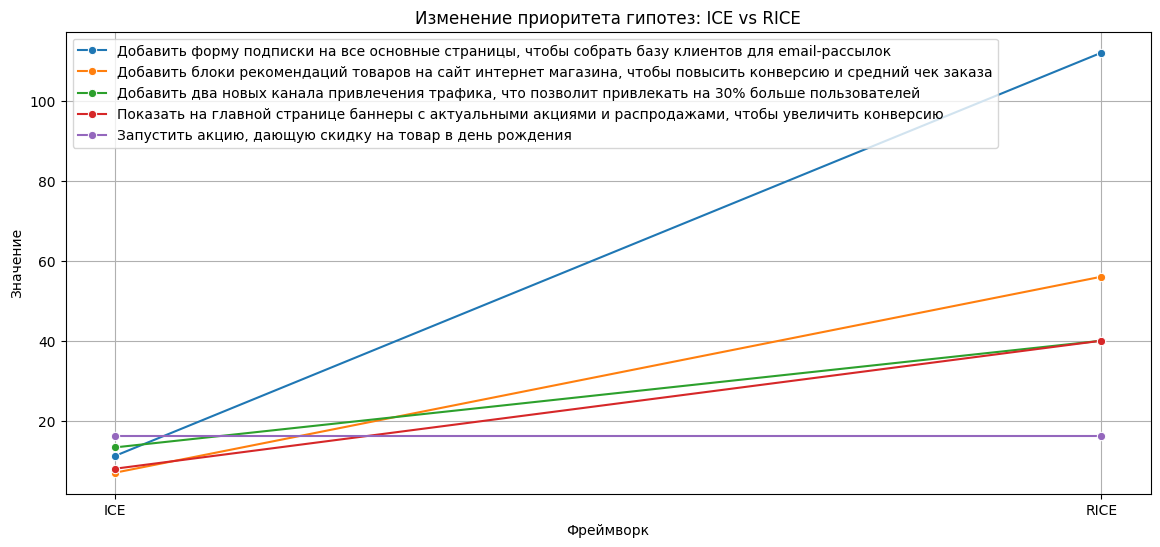

In [30]:
# подготовка датафреймов для вывода
df_slope = (
    df_hypothesis[['Hypothesis', 'ICE', 'RICE']]
    .sort_values(by='RICE', ascending=False)
    .head(5)
)
df_melted = df_slope.melt(id_vars='Hypothesis', value_vars=['ICE', 'RICE'], var_name='Metric', value_name='Value')

# вывод наклонного графика
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_melted, x='Metric', y='Value', hue='Hypothesis', marker='o', palette='tab10')
plt.title('Изменение приоритета гипотез: ICE vs RICE')
plt.xlabel('Фреймворк')
plt.ylabel('Значение')
plt.grid(True)
plt.legend(loc='upper left', fontsize=10)
plt.show()

<div style="border:solid gray 1px; padding: 20px">

**Выводы**
1. Наиболее перспективные гипотезы по ICE: 8, 0, 7, 6

2. Наиболее перспективные гипотезы по RICE: 7, 2, 0, 6.

3. Фактор Reach (количество затрагиваемых пользователей в результате изменения):
   - значительно увеличил приоритет гипотез 7 и 2
   - оставил без изменения приоритет лидера гипотез по ICE: 8

<a id="analysis_abtest"></a>
## Анализ A/B-теста

<a id="factors"></a>
### График кумулятивной выручки по группам

Построим график кумулятивной выручки `revenue` по дням и тестовым группам.

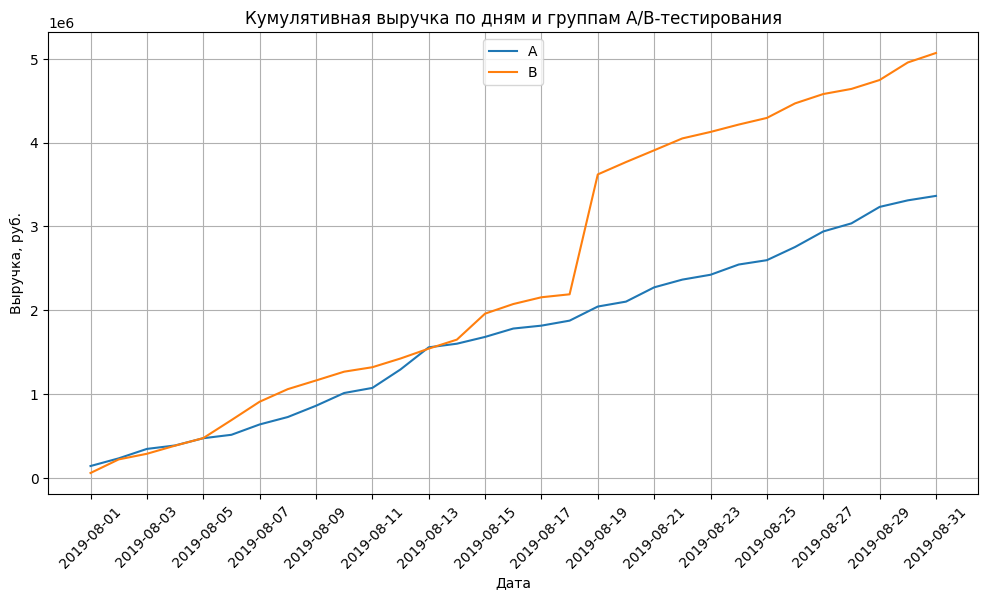

In [31]:
# создание массива уникальных пар значений дат и групп теста
datesGroups = df_orders[['date', 'group']].drop_duplicates()

# запись в переменную кумулятивных агрегированных данных о заказах
ordersAggregated = datesGroups.apply(
    lambda x: df_orders[
        np.logical_and(
            df_orders['date'] <= x['date'], df_orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionId': 'nunique',
            'visitorId': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

# запись в переменную кумулятивных агрегированных данных о посетителях
visitorsAggregated = datesGroups.apply(
    lambda x: df_visitors[
        np.logical_and(
            df_visitors['date'] <= x['date'], df_visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

# объединение кумулятивных данных в одной таблице
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

# вывод линейных графиков
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=cumulativeData,
    x="date",
    y="revenue",
    hue="group"
)
plt.title('Кумулятивная выручка по дням и группам A/B-тестирования')
plt.ylabel('Выручка, руб.')
plt.xlabel('Дата')
plt.legend(loc='upper center')
plt.grid()
plt.xticks(ticks=cumulativeData['date'].unique()[::2], rotation=45)
plt.show()

<div style="border:solid gray 1px; padding: 20px">

**Выводы:**

1. Выручка в обеих группах почти равномерно увеличивается в течение всего теста
   
2. Выручка в группе В резко выросла 19 августа. Это может сигнализировать о резком увеличении числа заказов, либо о появлении очень дорогих заказов в эту дату.

### График кумулятивного среднего чека по группам

Построим графики среднего чека по дням и по группам — разделим кумулятивную выручку `revenue` на кумулятивное число заказов `orders`:

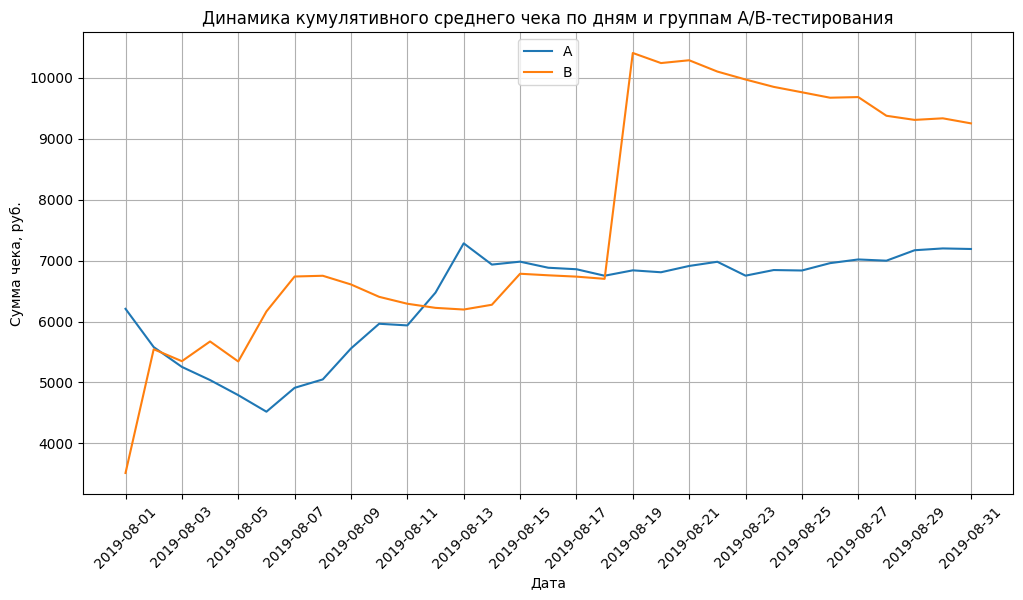

In [32]:
# вывод линейных графиков
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=cumulativeData,
    x="date",
    y=cumulativeData['revenue'] / cumulativeData['orders'],
    hue="group"
)
plt.title('Динамика кумулятивного среднего чека по дням и группам A/B-тестирования')
plt.ylabel('Сумма чека, руб.')
plt.xlabel('Дата')
plt.legend(loc='upper center')
plt.grid()
plt.xticks(ticks=cumulativeData['date'].unique()[::2], rotation=45)
plt.show()

<div style="border:solid gray 1px; padding: 20px">

**Вывод:**

1. Размер среднего чека в группе А почти равномерно растет ближе к концу теста
   
2. В группе В произошел скачок среднего чека 19 августа вероятно из-за крупного заказа в этот день
  
3. После 19 августа размер среднего чека в группе В снижается

### График относительного изменения кумулятивного среднего чека

Построим график относительного различия для среднего чека группы B к группе A. 

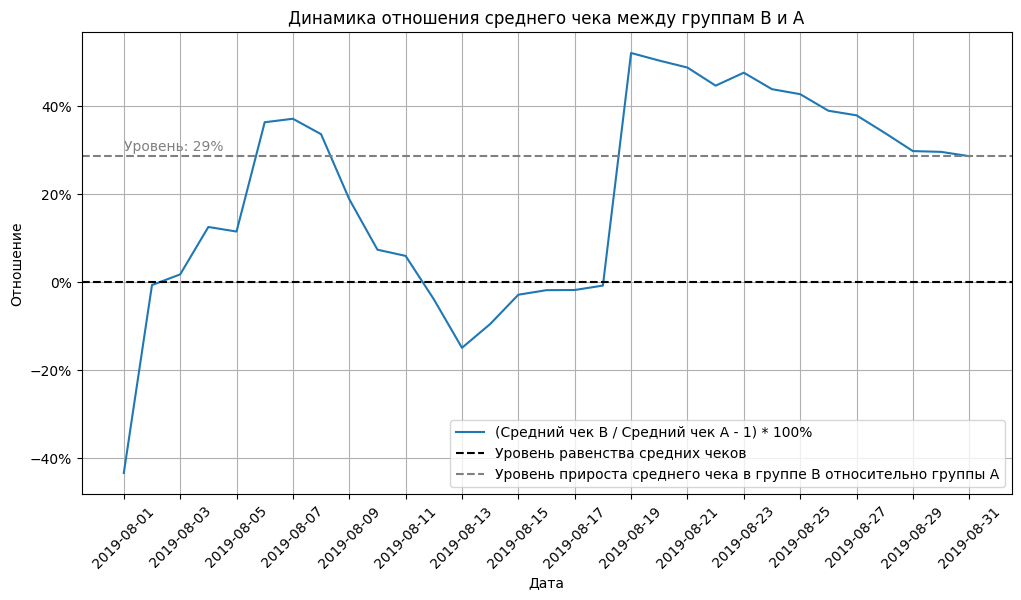

In [33]:
# подготовка данных для отображения
cumulativeData_merged = \
(
    cumulativeData.query('group == "A"')[['date', 'orders', 'revenue']]
    .merge(
        cumulativeData.query('group == "B"')[['date', 'orders', 'revenue']],
        left_on='date', 
        right_on='date', 
        how='left', 
        suffixes=['A', 'B']
    )
)

# добавление столбца прироста среднего чека
cumulativeData_merged['relative_check'] = (
    (
        (cumulativeData_merged['revenueB']/cumulativeData_merged['ordersB'])/
        (cumulativeData_merged['revenueA']/cumulativeData_merged['ordersA'])
    ) - 1
) * 100

# вывод линейного графика
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=cumulativeData_merged,
    x='date',
    y='relative_check',
    label='(Средний чек В / Средний чек А - 1) * 100%'
)
plt.title('Динамика отношения среднего чека между группам B и А')
plt.ylabel('Отношение')
plt.xlabel('Дата')
plt.grid()

# вывод уровня равенства
plt.axhline(
    y=0, 
    color='black', 
    linestyle='--', 
    label='Уровень равенства средних чеков'
)

# вывод уровня прироста
level_value = cumulativeData_merged['relative_check'].iloc[-1]
plt.axhline(
    y=level_value, 
    color='gray', 
    linestyle='--', 
    label='Уровень прироста среднего чека в группе В относительно группы А'
)
plt.text(
    x=cumulativeData_merged['date'].iloc[0],  
    y=level_value + 1.2,
    s=f'Уровень: {level_value:.0f}%',
    color='gray', 
    fontsize=10, 
    ha='left'
)

# вывод осей и легенды
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter())
plt.xticks(ticks=cumulativeData['date'].unique()[::2], rotation=45)
plt.legend(loc='lower right')
plt.show()

<div style="border:solid gray 1px; padding: 20px">

**Выводы:**

1. Результаты теста значительно и резко менялись в нескольких датах. Видимо, именно тогда были совершены аномальные заказы.
   
2. Если бы не было крупного заказа 19 августа, то группа B стабильно проигрывала бы группе A по размеру среднего чека во второй половине теста 

### График кумулятивного среднего количества заказов

Построим график кумулятивного среднего количества заказов на посетителя по группам.

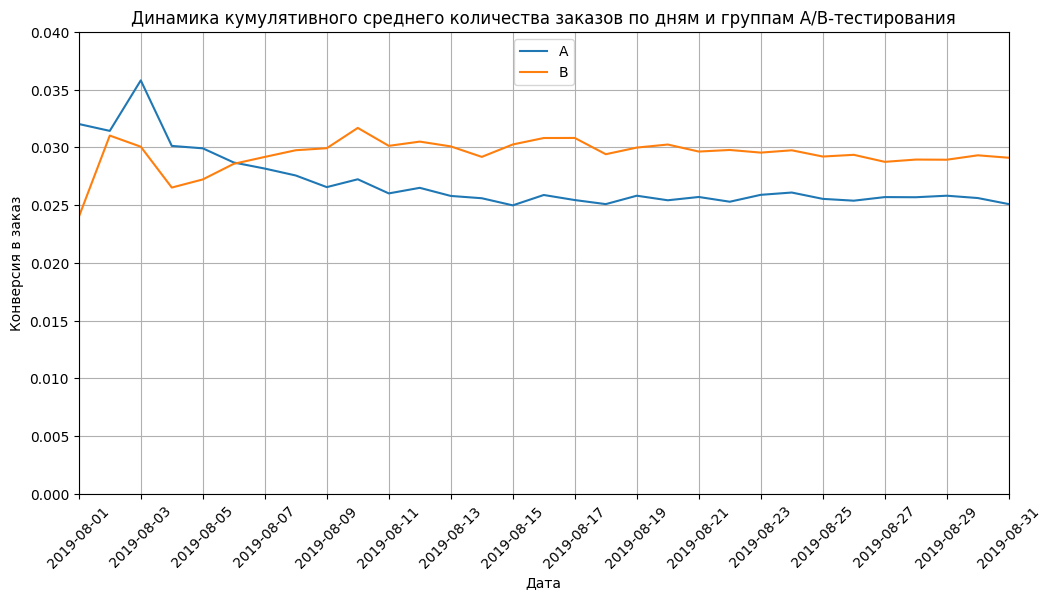

In [34]:
# добавление столбца среднего количество заказов на посетителя
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# вывод линейных графиков
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=cumulativeData,
    x="date",
    y="conversion",
    hue="group"
)
plt.title('Динамика кумулятивного среднего количества заказов по дням и группам A/B-тестирования')
plt.ylabel('Конверсия в заказ')
plt.xlabel('Дата')
plt.legend(loc='upper center')
plt.grid()
plt.xticks(ticks=cumulativeData['date'].unique()[::2], rotation=45)
plt.axis([dt(2019, 8, 1), dt(2019, 8, 31), 0, 0.04])
plt.show()

<div style="border:solid gray 1px; padding: 20px">

**Выводы:**

1. В начале теста группа A имела большее кумулятивное среднее количество заказов, но постепенно конверсия в группе B выросла и стала больше чем в группе А

2. Кумулятивное среднее количество заказов в группе А стабилизировалось во второй половине теста

3. Кумулятивное среднее количество заказов в группе В снизилось и стабилизировалось в последней декаде теста

### График относительного изменения кумулятивного среднего количества заказов

Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. 

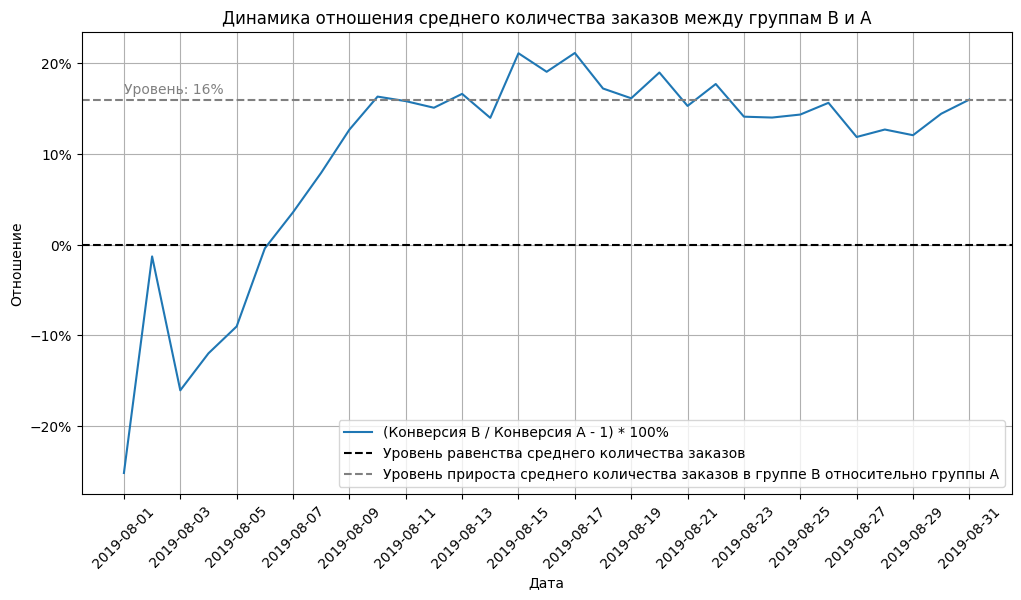

In [35]:
# подготовка данных для отображения
cumulativeData_merged = \
(
    cumulativeData.query('group == "A"')[['date', 'conversion']]
    .merge(
        cumulativeData.query('group == "B"')[['date', 'conversion']],
        left_on='date', 
        right_on='date', 
        how='left', 
        suffixes=['A', 'B']
    )
)

# добавление столбца прироста конверсии
cumulativeData_merged['relative_conversion'] = ((
    cumulativeData_merged['conversionB']/
    cumulativeData_merged['conversionA']
) - 1) * 100

# вывод линейного графика
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=cumulativeData_merged,
    x='date',
    y='relative_conversion',
    label='(Конверсия В / Конверсия А - 1) * 100%'
)
plt.title('Динамика отношения среднего количества заказов между группам B и А')
plt.ylabel('Отношение')
plt.xlabel('Дата')
plt.grid()

# вывод уровня равенства
plt.axhline(
    y=0, 
    color='black', 
    linestyle='--', 
    label='Уровень равенства среднего количества заказов'
)

# вывод уровня прироста
level_value = cumulativeData_merged['relative_conversion'].iloc[-1]
plt.axhline(
    y=cumulativeData_merged['relative_conversion'].iloc[-1], 
    color='gray', 
    linestyle='--', 
    label='Уровень прироста среднего количества заказов в группе В относительно группы А'
)
plt.text(
    x=cumulativeData_merged['date'].iloc[0],  
    y=level_value + 0.6,
    s=f'Уровень: {level_value:.0f}%',
    color='gray', 
    fontsize=10, 
    ha='left'
)

# вывод осей и легенды
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter())
plt.xticks(ticks=cumulativeData['date'].unique()[::2], rotation=45)
plt.legend(loc='lower right')
plt.show()

<div style="border:solid gray 1px; padding: 20px">

**Выводы:**

1. В начале теста группа B значительно проигрывала группе A по среднему количеству заказов, затем вышла вперёд
  
3. С середины теста среднее количество заказов на посетителя для группы B уменьшалось, а в последние 2 дня увеличилось

4. Отношение среднего количества заказов на посетителя установилось примерно на уровне **16%**.

5. Далее нужно проанализировать аномалии - возможно они изменят картину

### График количества заказов по пользователям

Построим точечный график количества заказов по пользователям.

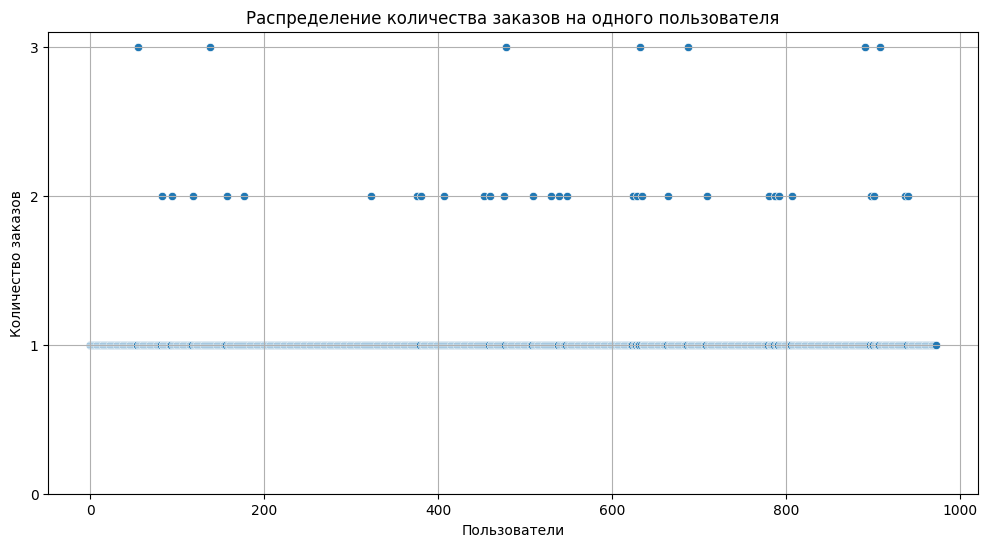

In [36]:
# расчет количества заказов на пользователя
ordersByUsers = (
    df_orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)
# вывод точечного графика
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=ordersByUsers,
    x=x_values,
    y='transactionId'
)
plt.title('Распределение количества заказов на одного пользователя')
plt.ylabel('Количество заказов')
plt.xlabel('Пользователи')
plt.grid()
plt.yticks(ticks=np.arange(0, 4, 1))
plt.show()

<div style="border:solid gray 1px; padding: 20px">

**Выводы:**

1. Большинство покупателей заказывали только один раз
   
2. Есть покупатели, сделавшие 2 и 3 заказа. Для оценки их аномальности необходимо рассчитать выборочные перцентили количества заказов на одного пользователя

### Расчет выборочных перцентилей количества заказов

Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.

In [37]:
# расчет и вывод информации о количестве заказов
percentili = [95, 99]
for p in percentili:
    value = round(np.percentile(ordersByUsers['transactionId'], p))
    display(
        Markdown(
            f'Не более {100 - p}% пользователей совершили больше **{value}** '
            f'заказ{"а" if value == 1 else "ов"}.'
        )
    )

Не более 5% пользователей совершили больше **1** заказа.

Не более 1% пользователей совершили больше **2** заказов.

<div style="border:solid gray 1px; padding: 20px">

**Вывод:** 

**1 заказ** на одного пользователя - граница для определения аномальных пользователей. Далее в исследовании исключим пользователей, совершивших 2 и более заказов

### График выручки по заказам

Построим точечный график стоимостей заказов.

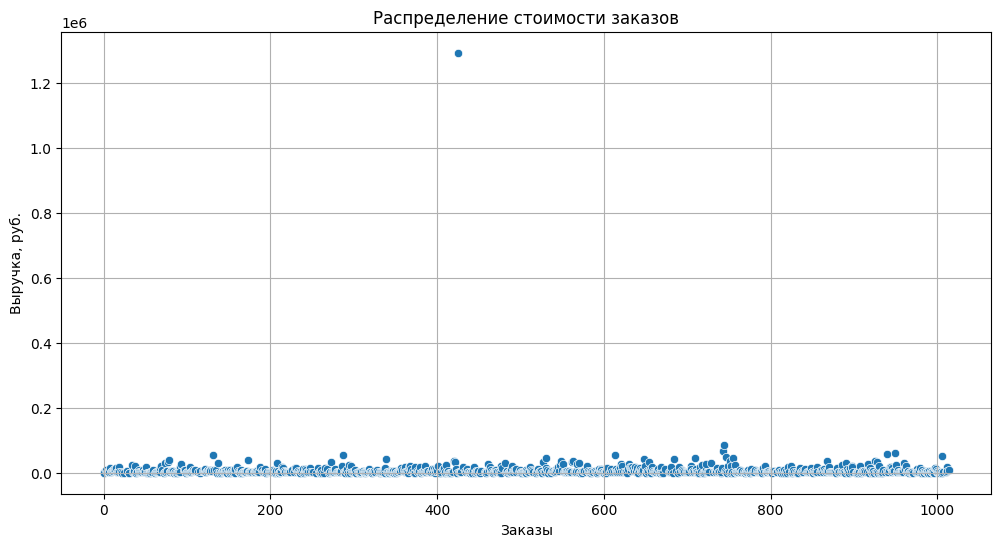

In [38]:
# вывод точечного графика
x_values = pd.Series(range(0,len(df_orders['revenue'])))
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df_orders,
    x=x_values,
    y='revenue'
)
plt.title('Распределение стоимости заказов')
plt.ylabel('Выручка, руб.')
plt.xlabel('Заказы')
plt.grid()
plt.show()

<div style="border:solid gray 1px; padding: 20px">

**Выводы:**

1. Большинство заказов на сумму до **100 000** руб.
   
2. Один заказ на сумму более 1,2 млн выглядит аномально

3. Необходимо рассчитать выборочные перцентили стоимости заказов

### Расчет выборочных перцентилей стоимости заказов

Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.

In [39]:
# расчет и вывод информации о стоимости заказов
percentili = [95, 99]
for p in percentili:
    value = round(np.percentile(df_orders['revenue'], p))
    display(
        Markdown(
            f'Не более {100 - p}% заказов дороже **{value:,}** руб.'.replace(",", " ")
        )
    )

Не более 5% заказов дороже **26 785** руб.

Не более 1% заказов дороже **53 904** руб.

<div style="border:solid gray 1px; padding: 20px">

**Вывод:** 

**30 000** руб. - граница стоимости заказа для определения аномальных пользователей. Далее в исследовании исключим пользователей, совершивших от 1% до 5% заказов с наибольшей стоимостью.

<a id="revenue_region"></a>
### Статистическая значимость различий в среднем количестве заказов по «сырым» данным

Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами тестирования без удаления пользователей с аномальным количеством заказов. Сформулируем гипотезы:

**H0** - нулевая гипотеза:
- различий в среднем количестве заказов на посетителя между группами нет

**H1** - альтернативная односторонняя гипотеза
- различия в среднем количестве заказов на посетителя между группами есть

Проверим гипотезу с помощью двустороннего теста «U-критерия Манна-Уитни» для независимых выборок. Если вероятность ошибочно отвергнуть нулевую гипотезу `p-value` окажется меньше уровня статистической значимости `alpha = 5%`, то отвергнем нулевую гипотезу в пользу альтернативной.

In [40]:
# запись в переменную информации о количестве заказов каждого пользователя группы А
ordersByUsersA = (
    df_orders.query('group == "A"')
    .groupby('visitorId', as_index=False)
    .agg(orders=('transactionId', 'nunique'))
)

# запись в переменную информации о количестве заказов каждого пользователя группы B
ordersByUsersB = (
    df_orders.query('group == "B"')
    .groupby('visitorId', as_index=False)
    .agg(orders=('transactionId', 'nunique'))
)

# запись в переменную выборки А для теста
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                df_visitors.query('group == "A"')['visitors'].sum() - 
                len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# запись в переменную выборки В для теста
sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                df_visitors.query('group == "B"')['visitors'].sum() - 
                len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# задание уровня статистической значимости
alpha = 0.05

# выполнение u-теста с двусторонней альтернативной гипотезой
p_value = st.mannwhitneyu(sampleA, sampleB)[1]

# проверка гипотезы
if p_value < alpha:
    display(
        Markdown(
            f'p_value=**{p_value:.2e}** < {alpha:.2%}\n\n'
            f' Отвергаем нулевую гипотезу: \
            есть статистически значимые различия в среднем числе заказов между группами.'
        )
    )
else:
    display(
        Markdown(
            f'p_value=**{p_value:.2%}** >= {alpha:.2%}\n\n'
            f' Не удалось отвергнуть нулевую гипотезу:\
            нет статистически значимых различий в среднем числе заказов между группами.'
        )
    )
# вывод информации о приросте числа заказов
display(
    Markdown(
        f'Относительный прирост среднего числа заказов группы B: '
        f'**{(sampleB.mean() / sampleA.mean() - 1):.2%}**'
    )
)

p_value=**1.10e-02** < 5.00%

 Отвергаем нулевую гипотезу:             есть статистически значимые различия в среднем числе заказов между группами.

Относительный прирост среднего числа заказов группы B: **15.99%**

<div style="border:solid gray 1px; padding: 20px">

**Вывод:** 

1. По данным с аномальным количеством заказов:

    - наблюдаемый относительный выигрыш **группы В** примерно: **16%**
    - прирост в среднем числе заказов между группами является статистически значимым

<a id="revenue_region"></a>
### Статистическая значимость различий в среднем чеке между группами по «сырым» данным

Посчитаем статистическую значимость различий в среднем чеке заказа между группами тестирования без удаления пользователей с аномальной стоимостью заказов. Сформулируем гипотезы:

**H0** - нулевая гипотеза:
- различий в среднем чеке заказа между группами нет

**H1** - альтернативная односторонняя гипотеза
- различия в среднем чеке заказа между группами есть

Проверим гипотезу с помощью двустороннего теста «U-критерия Манна-Уитни» для независимых выборок. Если вероятность ошибочно отвергнуть нулевую гипотезу `p-value` окажется меньше уровня статистической значимости `alpha = 5%`, то отвергнем нулевую гипотезу в пользу альтернативной.

In [41]:
# выполнение u-теста с двусторонней альтернативной гипотезой
p_value = st.mannwhitneyu(
    df_orders.query('group == "A"')['revenue'], 
    df_orders.query('group == "B"')['revenue']
)[1]

# проверка гипотезы
if p_value < alpha:
    display(
        Markdown(
            f'p_value=**{p_value:.2e}** < {alpha:.2%}\n\n'
            f' Отвергаем нулевую гипотезу: \
            есть статистически значимые различия в среднем чеке заказа между группами.'
        )
    )
else:
    display(
        Markdown(
            f'p_value=**{p_value:.2%}** >= {alpha:.2%}\n\n'
            f' Не удалось отвергнуть нулевую гипотезу:\
            нет статистически значимых различий в среднем чеке заказа между группами.'
        )
    )
# вывод информации о приросте среднего чека
display(
    Markdown(
        f'Относительный прирост среднего чека заказа группы B: '
        '**{0:.2%}**'.format(df_orders[df_orders['group']=='B']['revenue'].mean() /
                             df_orders[df_orders['group']=='A']['revenue'].mean()-1)
    )
)

p_value=**82.95%** >= 5.00%

 Не удалось отвергнуть нулевую гипотезу:            нет статистически значимых различий в среднем чеке заказа между группами.

Относительный прирост среднего чека заказа группы B: **28.66%**

<div style="border:solid gray 1px; padding: 20px">

**Выводы:** 

1. По данным с аномальной стоимостью заказов:

    - наблюдаемый относительный прирост в сумме среднего чека группы В примерно: **29%**
    - однако различие в среднем чеке заказа между группами не является статистически значимым
    - прирост в сумме среднего чека между группами может быть случайным и не указывать на реальное влияние изменений в группе В
      

2. Необходимо провести дополнительное исследование, исключив заказы с аномальной стоимостью в группе В

3. Получили подтверждение правильного выбора структурного критерия Манна-Уитни для проверки результатов А/В теста с аномальными выбросами, сильно сдвигающими параметрические результаты

<a id="average_number"></a>
### Статистическая значимость различий в среднем количестве заказов по «очищенным» данным

Примем за аномальных пользователей тех, кто совершил от **2 заказов** или совершил заказ дороже **30 000** рублей. Так мы исключим от 1% до 5% пользователей с наибольшим числом заказов и пользователей с дорогими заказами.

Составим список аномальных пользователей и подготовим выборки количества заказов по пользователям и по группам теста.

In [42]:
# запись в переменную максимального количества неаномальных заказов
orders_lim = np.percentile(ordersByUsers['transactionId'], 95)

# запись в переменную максимальной суммы неаномальных заказов
revenue_lim = 30000

# запись в переменную пользователей с количеством заказов >1
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA.query('orders > @orders_lim')['visitorId'],
        ordersByUsersB.query('orders > @orders_lim')['visitorId'],
    ],
    axis=0,
)

# запись в переменную пользователей с аномальными заказами
usersWithExpensiveOrders = df_orders.query('revenue > @revenue_lim')['visitorId']

# создание общего списка visitorId аномальных пользователей
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
)

#
# запись в переменную визитов аномальных пользователей
abnormalUsersAggregated = (
    df_orders.query('visitorId in @abnormalUsers')
    .groupby(['date', 'group'], as_index=False)
    .agg(visitors=('visitorId', 'count'))
)

# вычитание аномальных визитов из общих
merged_data = df_visitors.merge(
    abnormalUsersAggregated,
    on=['date', 'group'],
    suffixes=('_total', '_abnormal'),
    how='left'
)
merged_data['visitors_abnormal'] = merged_data['visitors_abnormal'].fillna(0)
merged_data['visitors'] = merged_data['visitors_total'] - merged_data['visitors_abnormal']
merged_data = merged_data[['date', 'group', 'visitors']]

# создание выборки А для теста
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
        np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                merged_data.query('group == "A"')['visitors'].sum() - 
                len(ordersByUsersA.query('orders <= @orders_lim'))
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# создание выборки В для теста
sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                merged_data.query('group == "B"')['visitors'].sum() - 
                len(ordersByUsersB.query('orders <= @orders_lim'))
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами тестирования после исключения аномальных пользователей. Сформулируем гипотезы:

**H0** - нулевая гипотеза:
- различий в среднем количестве заказов на посетителя между группами нет

**H1** - альтернативная односторонняя гипотеза
- различия в среднем количестве заказов на посетителя между группами есть

Проверим гипотезу с помощью двустороннего теста «U-критерия Манна-Уитни» для независимых выборок. Если вероятность ошибочно отвергнуть нулевую гипотезу `p-value` окажется меньше уровня статистической значимости `alpha = 5%`, то отвергнем нулевую гипотезу в пользу альтернативной.

In [43]:
# выполнение u-теста с двусторонней альтернативной гипотезой
p_value = st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]

# проверка гипотезы
if p_value < alpha:
    display(
        Markdown(
            f'p_value=**{p_value:.2e}** < {alpha:.2%}\n\n'
            f' Отвергаем нулевую гипотезу: \
            есть статистически значимые различия в среднем числе заказов между группами.'
        )
    )
else:
    display(
        Markdown(
            f'p_value=**{p_value:.2%}** >= {alpha:.2%}\n\n'
            f' Не удалось отвергнуть нулевую гипотезу:\
            нет статистически значимых различий в среднем числе заказов между группами.'
        )
    )
# вывод информации о приросте числа заказов
display(
    Markdown(
        f'Относительный прирост среднего числа заказов группы B: '
        f'**{(sampleBFiltered.mean() / sampleAFiltered.mean() - 1):.2%}**'
    )
)

p_value=**1.24e-02** < 5.00%

 Отвергаем нулевую гипотезу:             есть статистически значимые различия в среднем числе заказов между группами.

Относительный прирост среднего числа заказов группы B: **17.99%**

Построим график кумулятивного среднего количества заказов на посетителя по группам после исключения аномальных пользователей.

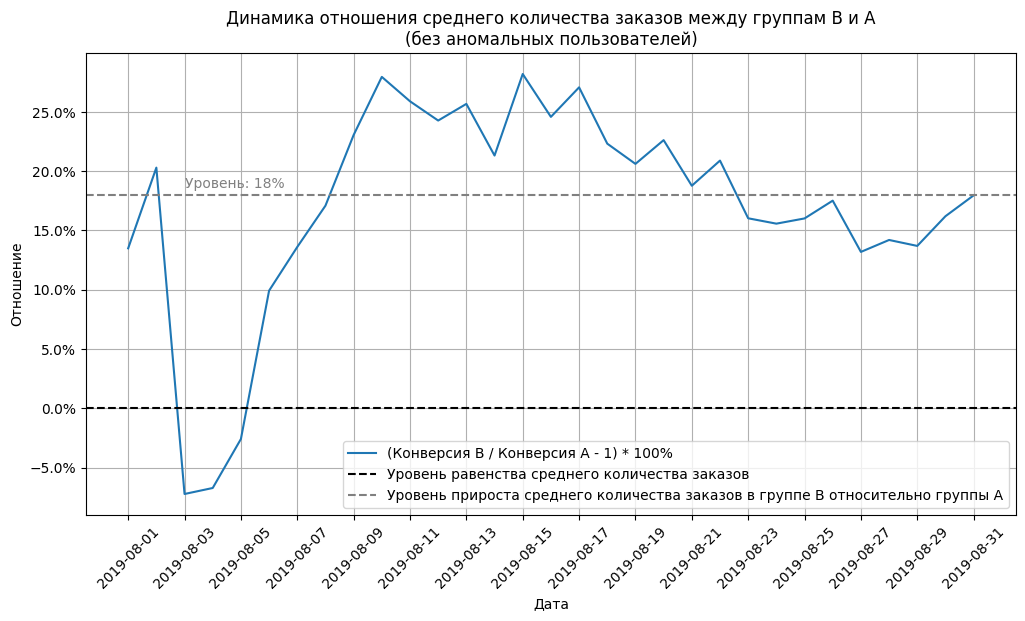

In [44]:
# запись в переменную кумулятивных агрегированных данных без аномальных заказов
ordersAggregated = datesGroups.apply(
    lambda x: df_orders[
            (df_orders['date'] <= x['date']) & 
            (df_orders['group'] == x['group']) &
            (~df_orders['visitorId'].isin(abnormalUsers))
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionId': 'nunique',
            'visitorId': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

# запись в переменную кумулятивных агрегированных данных без аномальных посетителей
visitorsAggregated = datesGroups.apply(
    lambda x: merged_data[
        np.logical_and(
            merged_data['date'] <= x['date'], 
            merged_data['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

# объединение кумулятивных данных в одной таблице
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

# добавление столбца среднего количество заказов на посетителя
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# подготовка данных для отображения
cumulativeData_merged = \
(
    cumulativeData.query('group == "A"')[['date', 'conversion']]
    .merge(
        cumulativeData.query('group == "B"')[['date', 'conversion']],
        left_on='date', 
        right_on='date', 
        how='left', 
        suffixes=['A', 'B']
    )
)

# добавление столбца прироста конверсии
cumulativeData_merged['relative_conversion'] = ((
    cumulativeData_merged['conversionB']/
    cumulativeData_merged['conversionA']
) - 1) * 100

# вывод линейного графика
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=cumulativeData_merged,
    x='date',
    y='relative_conversion',
    label='(Конверсия В / Конверсия А - 1) * 100%'
)
plt.title('Динамика отношения среднего количества заказов между группам B и А\n'
          '(без аномальных пользователей)')
plt.ylabel('Отношение')
plt.xlabel('Дата')
plt.grid()

# вывод уровня равенства
plt.axhline(
    y=0, 
    color='black', 
    linestyle='--', 
    label='Уровень равенства среднего количества заказов'
)

# вывод уровня прироста
level_value = cumulativeData_merged['relative_conversion'].iloc[-1]
plt.axhline(
    y=cumulativeData_merged['relative_conversion'].iloc[-1], 
    color='gray', 
    linestyle='--', 
    label='Уровень прироста среднего количества заказов в группе В относительно группы А'
)
plt.text(
    x=cumulativeData_merged['date'].iloc[2],  
    y=level_value + 0.6,
    s=f'Уровень: {level_value:.0f}%',
    color='gray', 
    fontsize=10, 
    ha='left'
)
# вывод осей и легенды
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter())
plt.xticks(ticks=cumulativeData['date'].unique()[::2], rotation=45)
plt.legend(loc='lower right')
plt.show()

<div style="border:solid gray 1px; padding: 20px">

**Вывод:** 

1. По данным без аномальных пользователей:

    - наблюдаемый относительный выигрыш группы В по конверсии из посетителя в заказ вырос примерно: с **16%** до **18%**
    - различия в среднем числе заказов между группами являются статистически значимыми
    - на графике рост выигрыша конверсии группы В стал отчетливее в последние четыре дня теста

<a id="average_check"></a>
### Статистическая значимость различий в среднем чеке между группами по «очищенным» данным

Посчитаем статистическую значимость различий в среднем чеке заказа между группами тестирования без удаления пользователей с аномальной стоимостью заказов. Сформулируем гипотезы:

**H0** - нулевая гипотеза:
- различий в среднем чеке заказа между группами нет

**H1** - альтернативная односторонняя гипотеза
- различия в среднем чеке заказа между группами есть

Проверим гипотезу с помощью двустороннего теста «U-критерия Манна-Уитни» для независимых выборок. Если вероятность ошибочно отвергнуть нулевую гипотезу `p-value` окажется меньше уровня статистической значимости `alpha = 5%`, то отвергнем нулевую гипотезу в пользу альтернативной.

In [45]:
# выполнение u-теста с двусторонней альтернативной гипотезой
p_value = st.mannwhitneyu(
    df_orders[
    np.logical_and(
        df_orders['group'] == 'A',
        ~df_orders['visitorId'].isin(abnormalUsers),
    )
    ]['revenue'], 
    df_orders[
    np.logical_and(
        df_orders['group'] == 'B',
        ~df_orders['visitorId'].isin(abnormalUsers),
    )
    ]['revenue']
)[1]

# проверка гипотезы
if p_value < alpha:
    display(
        Markdown(
            f'p_value=**{p_value:.2e}** < {alpha:.2%}\n\n'
            f' Отвергаем нулевую гипотезу: \
            есть статистически значимые различия в среднем чеке заказа между группами.'
        )
    )
else:
    display(
        Markdown(
            f'p_value=**{p_value:.2%}** >= {alpha:.2%}\n\n'
            f' Не удалось отвергнуть нулевую гипотезу:\
            нет статистически значимых различий в среднем чеке заказа между группами.'
        )
    )
# вывод информации о приросте среднего чека
display(
    Markdown(
        f'Относительный прирост среднего чека заказа группы B: '
        '**{0:.2%}**'.format(
            df_orders[
            np.logical_and(
                df_orders['group'] == 'B',
                ~df_orders['visitorId'].isin(abnormalUsers),
            )
            ]['revenue'].mean() /
            df_orders[
            np.logical_and(
                df_orders['group'] == 'A',
                ~df_orders['visitorId'].isin(abnormalUsers),
            )
            ]['revenue'].mean()-1)
    )
)

p_value=**82.90%** >= 5.00%

 Не удалось отвергнуть нулевую гипотезу:            нет статистически значимых различий в среднем чеке заказа между группами.

Относительный прирост среднего чека заказа группы B: **-1.06%**

Построим график относительного различия для среднего чека группы B к группе A после исключения аномальных заказов.

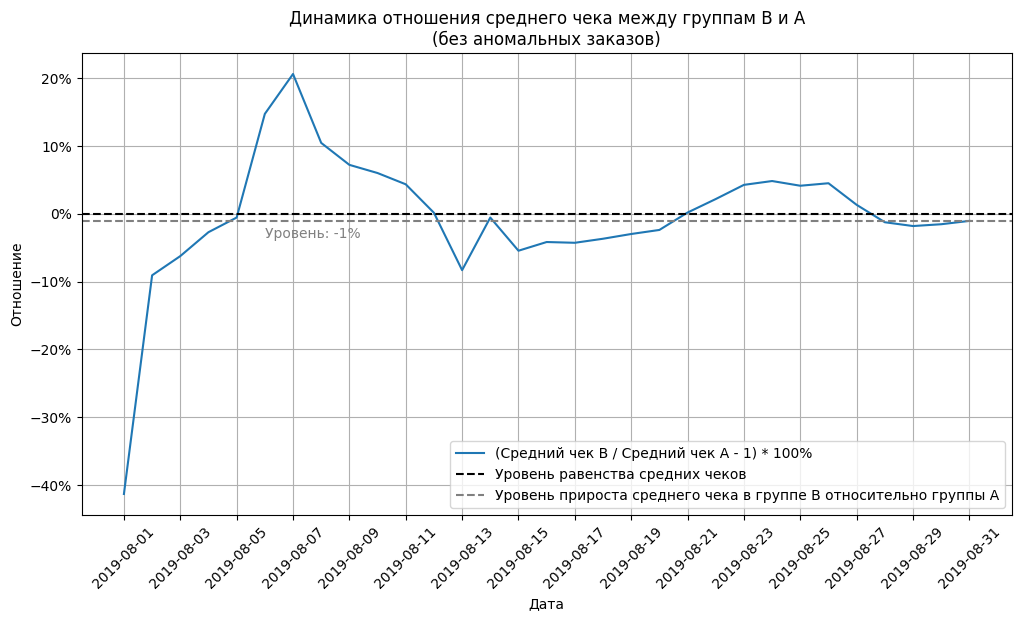

In [46]:
# подготовка данных для отображения
cumulativeData_merged = \
(
    cumulativeData.query('group == "A"')[['date', 'orders', 'revenue']]
    .merge(
        cumulativeData.query('group == "B"')[['date', 'orders', 'revenue']],
        left_on='date', 
        right_on='date', 
        how='left', 
        suffixes=['A', 'B']
    )
)

# добавление столбца прироста среднего чека
cumulativeData_merged['relative_check'] = ((
    (cumulativeData_merged['revenueB']/cumulativeData_merged['ordersB'])/
    (cumulativeData_merged['revenueA']/cumulativeData_merged['ordersA'])
) - 1) * 100

# вывод линейного графика
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=cumulativeData_merged,
    x='date',
    y='relative_check',
    label='(Средний чек В / Средний чек А - 1) * 100%'
)
plt.title('Динамика отношения среднего чека между группам B и А\n'
          '(без аномальных заказов)')
plt.ylabel('Отношение')
plt.xlabel('Дата')
plt.grid()

# вывод уровня равенства
plt.axhline(
    y=0, 
    color='black', 
    linestyle='--', 
    label='Уровень равенства средних чеков'
)

# вывод уровня прироста
level_value = cumulativeData_merged['relative_check'].iloc[-1]
plt.axhline(
    y=level_value, 
    color='gray', 
    linestyle='--', 
    label='Уровень прироста среднего чека в группе В относительно группы А'
)
plt.text(
    x=cumulativeData_merged['date'].iloc[5],  
    y=level_value - 2.5,
    s=f'Уровень: {level_value:.0f}%',
    color='gray', 
    fontsize=10, 
    ha='left'
)

# вывод осей и легенды
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter())
plt.xticks(ticks=cumulativeData['date'].unique()[::2], rotation=45)
plt.legend(loc='lower right')
plt.show()

<a id="cumulative_revenue"></a>
### График кумулятивной выручки по группам по "очищенным" данным

Построим график кумулятивной выручки `revenue` по дням и тестовым группам после исключения аномальных заказов.

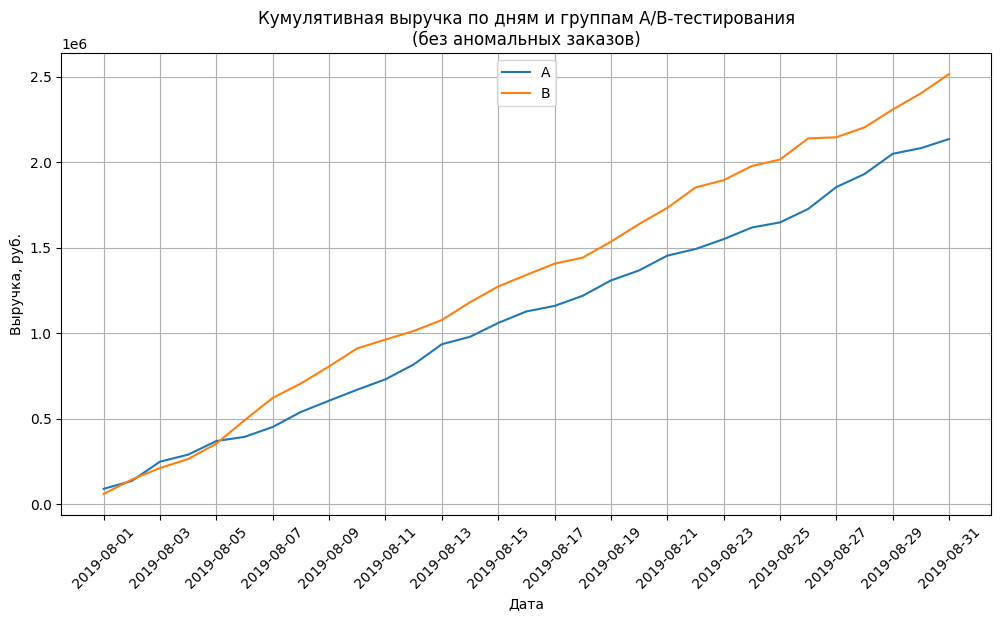

In [47]:
# вывод линейных графиков
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=cumulativeData,
    x="date",
    y="revenue",
    hue="group"
)
plt.title('Кумулятивная выручка по дням и группам A/B-тестирования\n'
          '(без аномальных заказов)')
plt.ylabel('Выручка, руб.')
plt.xlabel('Дата')
plt.legend(loc='upper center')
plt.grid()
plt.xticks(ticks=cumulativeData['date'].unique()[::2], rotation=45)
plt.show()

<div style="border:solid gray 1px; padding: 20px">

**Выводы:** 

1. По данным без аномальных заказов:

    - наблюдаемый относительный прирост среднего чека заказа группы B: **-1%**
    - нет статистически значимых различий в среднем чеке заказа между группами.
    - относительное различие для среднего чека между группами стабилизировалось на графике около нулевого уровня
    - скорость роста выручки (угол наклона линиии на графике) в группе В выше, чем в группе А

<a id="research_results"></a>
## Итоги исследования

Результаты приоритизации гипотез по фреймворкам ICE / RICE и анализ результатов A/B-теста позволят отделу маркетинга реализовать стратегию по увеличению выручки.

**Установлено по результатам теста**:


1. Различия в среднем чеке между тестовыми группами практически нет
   
2. В **группе В** выросла и стабилизировалась конверсия в заказ:

   - по "сырым" данным примерно на **16%**
   - по "очищенным" от аномальных пользователей данным примерно на **18%** 

3. Выручка в обеих группах почти равномерно увеличивается в течение всего теста, причем скорость роста выручки в **группе В** выше чем в группе А за счет увеличения количества заказов

4. Тест следует остановить и признать его успешным - **группа В приносит больше выручки, чем группа А**


   
**Рекомендации**:

1. Для правильной интерпретации последущих А/В тестов проверить корректность работы системы сплитования, которая распределяет пользователей по группам.
   
2. Для увеличения среднего чека протестировать вторую по приоритетности RICE гипотезу "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа"

[Вернуться в начало](#intro)